# Getting started with CUDA

### Setup

In [1]:
import torch, os, math
import torchvision as tv
import torchvision.transforms.functional as tvf
from torchvision import io
import matplotlib.pyplot as plt
from torch.utils.cpp_extension import load_inline

In [2]:
!nvidia-smi

Sat Feb 17 15:08:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        On  | 00000000:01:00.0 Off |                  N/A |
|  0%   23C    P8               7W / 280W |     47MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
img = io.read_image("../../imgs/what_is_a.png")
print(img.shape)
img[:2, :3, :4]

torch.Size([4, 1034, 1448])


tensor([[[254, 254, 254, 254],
         [254, 254, 254, 254],
         [253, 253, 253, 253]],

        [[254, 254, 254, 254],
         [254, 254, 254, 254],
         [253, 253, 253, 253]]], dtype=torch.uint8)

In [7]:
def show_img(x, figsize=(4,3), **kwargs):
    plt.figure(figsize=figsize)
    plt.axis("off")
    if len(x.shape)==3: 
        x = x.permute(1,2,0)  #CHW -> HWC
    plt.imshow(x.cpu(), **kwargs)

In [8]:
img2 = tvf.resize(img, 150, antialias=True)
ch, h, w = img2.shape
ch, h, w, h*w

(4, 150, 210, 31500)

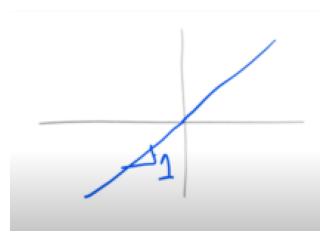

In [9]:
show_img(img2)